In [67]:
from astropy.io import fits
from astropy.table import Table, join, unique

from astropy.coordinates import SkyCoord
import astropy.units as u

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import pyphot
import sys
sys.path.append('../corv/src')
import corv


plt.style.use('stefan.mplstyle')

building montreal da model
could not find pickled WD models
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [14]:
catalog = Table.read('data/01_ir_excess.fits')
allstars = Table.read('data/allstars.dat.gz', format='ipac')

In [15]:
allstars[0:3]

GaiaEDR3,ra,e_ra,dec,e_dec,parallax,e_parallax,pmra,e_pmra,pmdec,e_pmdec,phot_g_mean_mag,rfg,phot_bp_mean_mag,rfbp,phot_rp_mean_mag,rfrp,excess_bp_rp_factor,ruwe,IPDfmp,RV,e_RV,r_RV,f_RV,GCNSprob,Wdprob,w1,e_w1,w2,e_w2,w3,e_w3,w4,e_w4,abs_g,abs_bp,abs_rp,abs_w1,abs_w2,abs_w3,abs_w4,parallax_over_error
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,str19,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2.33467e+18,0.002565,0.03305,-26.3653495,0.025,14.697,0.03698,23.497,0.0368,-62.339,0.02981,15.7779,1586.04,17.4299,150.54,14.5407,689.37,1.4738,1.01,0,--,--,--,F,1.0,0.0,11.799,0.012,11.606,0.009,11.1,0.128,9.074,--,11.614043470879967,13.266043470879964,10.376843470879965,7.635143470879965,7.442143470879965,6.936143470879965,4.910143470879965,397.4310438074635
5.30862e+17,0.0056369,0.00951,70.8873639,0.00858,10.282,0.01075,-52.864,0.0121,17.787,0.01162,10.8521,3717.03,11.3022,1136.43,10.2396,1764.44,1.219,0.82,0,-26.204,0.4477,2018A&A...616A...1G,T,1.0,0.0,8.965,0.013,9.024,0.009,8.937,0.027,8.649,0.333,5.9124879976550755,6.3625879976550745,5.299987997655075,4.025387997655075,4.0843879976550745,3.997387997655075,3.7093879976550745,956.4651162790699
2.7454e+18,0.0093361,0.03793,6.5110167,0.03139,16.26,0.05893,117.495,0.06235,9.521,0.03129,16.2772,1834.97,18.2886,116.81,14.9456,863.36,1.5487,0.94,0,--,--,--,F,1.0,0.013,11.866,0.013,11.66,0.009,11.63,0.218,8.881,--,12.332802706290249,14.344202706290247,11.001202706290247,7.921602706290247,7.715602706290247,7.685602706290248,4.936602706290247,275.9205837434244


Text(0, 0.5, 'W1 - W2')

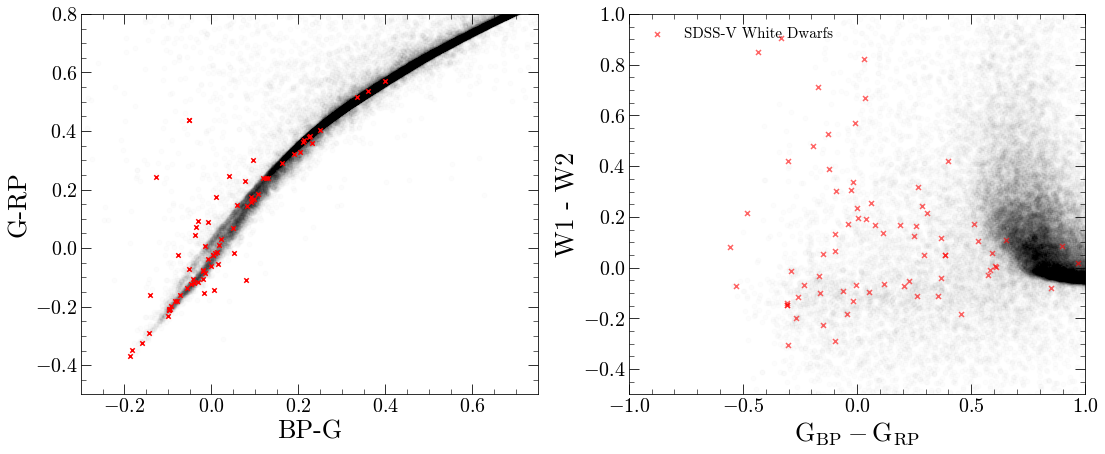

In [33]:
plt.figure(figsize=(18,7))

plt.subplot(1,2,1)

plt.scatter(catalog['BP-G'], catalog['G-RP'], marker = 'x', s = 20, c = 'red')
plt.scatter(allstars['phot_bp_mean_mag'] - allstars['phot_g_mean_mag'], allstars['phot_g_mean_mag'] - allstars['phot_rp_mean_mag'], c = 'k', alpha = 0.01, zorder = 0)

plt.xlabel(r'BP-G')
plt.ylabel(r'G-RP')

plt.xlim(-.3, 0.75)
plt.ylim(-0.5, 0.8)

plt.subplot(1,2,2)

plt.scatter(allstars['abs_bp'] - allstars['abs_rp'], allstars['abs_w1'] - allstars['abs_w2'], c = 'k', alpha = 0.01)
plt.scatter(catalog['abs_bp'] - catalog['abs_rp'], catalog['abs_w1'] - catalog['abs_w2'], c = 'red', alpha = 0.6, marker = 'x', label = 'SDSS-V White Dwarfs')

plt.legend(framealpha = 0)

plt.ylim(-0.5,1)
plt.xlim(-1,1)

plt.xlabel(r'$G_{BP} - G_{RP}$')
plt.ylabel('W1 - W2')

In [113]:
from pyphot import unit


base_wavl, tremblay, table = corv.utils.build_montreal_da(path = '/home/sarsene1/corv/src/corv/models/montreal_da', flux_unit = 'flam')

bp_g = []
g_rp = []

lib = pyphot.get_library()
filters = [lib['Gaia_G'], lib['Gaia_BP'], lib['Gaia_RP']]

logg = 8
teffs = np.linspace(5000, 100000, 100)

for i in tqdm(range(len(teffs))):
    spec = tremblay((teffs[i], logg))
    
    fluxes = [filters[j].get_flux(base_wavl * unit['angstrom'], spec* unit['erg/s/cm**2/angstrom'], axis=1).to('erg/s/cm**2/angstrom').value for j in range(len(filters))]
    mags = [-2.5 * np.log10(fluxes[j]) - filters[j].Vega_zero_mag for j in range(len(filters))]
    
    bp_g.append(mags[1] - mags[0])
    g_rp.append(mags[0] - mags[2])
    
bp_g = list(reversed(bp_g))
g_rp = list(reversed(g_rp))
    
catalog['diffs'] = catalog['G-RP'] - np.interp(catalog['BP-G'], bp_g, g_rp)

100%|██████████| 100/100 [00:01<00:00, 54.58it/s]


Text(0, 0.5, 'G-RP')

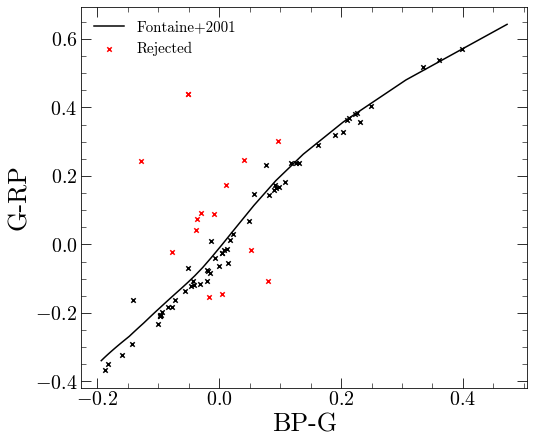

In [128]:
mask = np.all([catalog['diffs'] < 0.1, catalog['diffs'] > -0.1], axis = 0)

plt.figure(figsize=(8,7))

plt.plot(bp_g_8, g_rp_8, c = 'k', label = 'Fontaine+2001')
plt.scatter(catalog[~mask]['BP-G'], catalog[~mask]['G-RP'], marker = 'x', s = 20, c = 'red', label='Rejected')
plt.scatter(catalog[mask]['BP-G'], catalog[mask]['G-RP'], marker = 'x', s = 20, c = 'k')

plt.legend(framealpha=0)

plt.xlabel(r'BP-G')
plt.ylabel(r'G-RP')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'W1 - W2')

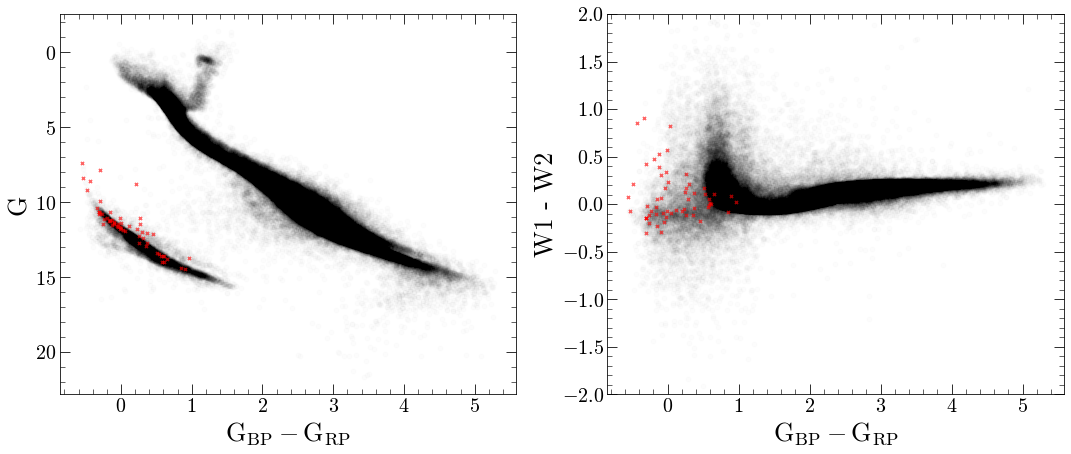

In [130]:
plt.figure(figsize=(18,7))

plt.subplot(1,2,1)

plt.scatter(allstars['abs_bp'] - allstars['abs_rp'], allstars['abs_g'], c = 'k', alpha = 0.01)
#plt.scatter(catalog['abs_bp'] - catalog['abs_rp'], catalog['abs_g'],  c = 'red', alpha = 0.6, marker = 'x', s = 10, label = 'SDSS-V White Dwarfs')
plt.scatter(catalog[mask]['abs_bp'] - catalog[mask]['abs_rp'], catalog[mask]['abs_g'],  c = 'red', alpha = 0.6, marker = 'x', s = 10)


plt.xlabel(r'$G_{BP} - G_{RP}$')
plt.ylabel('G')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)

plt.scatter(allstars['abs_bp'] - allstars['abs_rp'], allstars['abs_w1'] - allstars['abs_w2'], c = 'k', alpha = 0.01)
#plt.scatter(catalog['abs_bp'] - catalog['abs_rp'], catalog['abs_w1'] - catalog['abs_w2'], c = 'red', alpha = 0.6, marker = 'x', s = 10, label = 'SDSS-V White Dwarfs')
plt.scatter(catalog[mask]['abs_bp'] - catalog[mask]['abs_rp'], catalog[mask]['abs_w1'] - catalog[mask]['abs_w2'], c = 'red', alpha = 0.6, marker = 'x', s = 10)


plt.legend(framealpha = 0)

plt.ylim(-2,2)

plt.xlabel(r'$G_{BP} - G_{RP}$')
plt.ylabel('W1 - W2')